I'm not quite sure how to approach this problem: http://puzzlor.com/2014-12_Electrifying.html so I'm going to work through this http://isaacslavitt.com/2015/02/26/combinatorial-optimization/ solution set to understand where I can apply these tools to other puzzlor problems

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
np.set_printoptions(precision=2)

In [2]:
neighborhoods = ['A6', 'B2', 'B4', 'B5', 'B7', 'C5', 'C10', 'D9',
                 'E2', 'E6', 'E8', 'F3', 'F5', 'G8', 'G9', 'H3',
                 'H5', 'H7', 'H8', 'J4']
# this is amazing:
array_to_alphanum = lambda(i,j): '{}{}'.format('JIHGFEDCBA'[i],range(1,11)[j])
alphanum_to_array = lambda n: ['JIHGFEDCBA'.index(n[0]),int(n[1:])-1]

In [3]:
N = np.array(map(alphanum_to_array,neighborhoods))

In [4]:
# define the loss function
def dists(s,N):
    """
    determine each neighborhood's dist from a given point
    
    s - a single point
    N - the array of neighborhoods placements
    """
    inds = N - np.array(s)
    
    return np.sqrt(inds[:,0]**2 + inds[:,1]**2)   

In [5]:
dists([5,5],N)

array([ 4.  ,  5.  ,  3.61,  3.16,  3.16,  2.24,  4.47,  3.16,  4.  ,
        0.  ,  2.  ,  3.16,  1.41,  2.83,  3.61,  4.24,  3.16,  3.16,
        3.61,  5.39])

In [6]:
def coords_to_dist_matrix(ss, N):
    """
    returns the Nplants x Nneigh matrix of all Euclidean dists
    
    ss  - an array of multiple power plant locations
    N - 2d array of neightborhood locations
    """
    return np.vstack(dists(s,N) for s in ss)    # vstack stacks the outputs of the iterator and gives the matrix

In [7]:
# now test it
ss0 = [(1,2), (0,6), (8,3)]
coords_to_dist_matrix(ss0,N)

array([[ 8.54,  7.07,  7.07,  7.28,  8.06,  6.32,  9.22,  7.81,  4.12,
         5.  ,  6.4 ,  3.  ,  3.61,  5.39,  6.32,  1.  ,  2.24,  4.12,
         5.1 ,  1.41],
       [ 9.06,  9.43,  8.54,  8.25,  8.  ,  7.28,  7.62,  6.32,  7.07,
         5.1 ,  5.1 ,  5.66,  4.47,  3.16,  3.61,  4.47,  2.83,  2.  ,
         2.24,  3.  ],
       [ 2.24,  2.  ,  0.  ,  1.  ,  3.  ,  1.41,  6.08,  5.39,  3.61,
         3.61,  5.  ,  4.12,  4.12,  6.4 ,  7.07,  6.08,  6.08,  6.71,
         7.21,  8.  ]])

In [8]:
# return the smallest value, since that is the power plant that will be responsible
def responsibilities(ss, N):
    """
    Given a list of where power plants are located, return an array of which is closest to each location
    
    ss - array of power plant locations
    N - 2d array of neighborhood locations
    """
    ds = coords_to_dist_matrix(ss, N)
    # argmin axis = 0 returns the column in which the row in which the min occurs
    # effectively, we iterate over cols and find the row with the min
    return np.argmin(ds, axis=0)  

In [9]:
responsibilities(ss0, N)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 1, 0, 0, 1, 1, 0])

In [10]:
def responsible_dist_sums(ss, N, rs=()):
    """
    retunrs the sums of edge lengths for each power plant, accounting for which is closest
    
    ss - array of multiple (x,y) power plant placements
    N - 2D array of neighborhood locations
    rs - (optional) forced assignment of responsibility
    """
    if not len(rs):
        rs = responsibilities(ss, N)
    
    sums = [dists(s, N)[np.argwhere(rs==i)].sum() for i,s in enumerate(ss)]
    return sums
    
responsible_dist_sums(ss0, N)

[11.255832815336875, 11.003896913132159, 33.329311428233581]

In [11]:
# defining the energy function for simulated annealing
def E(ss, N, rs=()):
    """
    objective function, returns the cost, in millions, to connect all neighborhoods
    
    ss - array of multiple (x,y) power plant placements
    N - 2D array of neighborhood locations
    rs - (optional) forced assignment of responsibility
    """
    return(sum(responsible_dist_sums(ss, N, rs=rs)))

E(ss0, N)

55.589041156702613

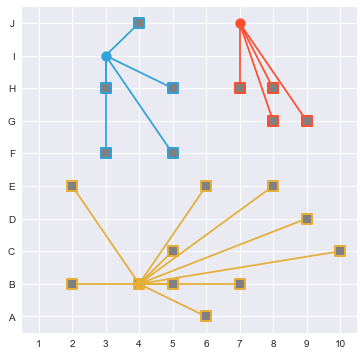

In [12]:
# i need to get better at data viz!
def plot_placements(ss, N, rs=()):
    """
    plot the neighborhoods and power plants together
    
    """
    
    plt.figure(figsize=(6,6))
    colors = ['#30a2da', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b']
    
    # use this to flip the array so that (0,0) is at top left
    height = N[:, 0].max()
    
    if not len(rs):
        rs = responsibilities(ss, N)
        
        # plot the neighborhoods
    for i, (y, x) in enumerate(N):
        # plot the responsibility edges
        sy, sx = ss[rs[i]]
        plt.plot((x, sx), (height - y, height - sy), c=colors[rs[i]], zorder=1)
        
        # plot the neighborhoods themselves
        plt.scatter(x, height - y, marker='s', s=100, c='gray', lw=2,
                    edgecolor=colors[rs[i]], zorder=2)
    
    # plot the power plants
    for i, (y, x) in enumerate(np.asarray(ss)):
        plt.scatter(x, height - y, s=100, c=colors[i], zorder=3)
    
    # tweak the settings
    plt.grid(True)
    plt.xlim(-0.5, 9.5)
    plt.ylim(-0.5, 9.5)
    plt.xticks(np.arange(10), np.arange(1, 11))
    plt.yticks(np.arange(10), 'ABCDEFGHIJ')
    plt.show()
    
plot_placements(ss0, N)
    

In [13]:
def sim_anneal(energy, perturb, n0, ntrial=100000, t0=2.0, thermo=0.9,
               reanneal=1000, verbose=True, other_func=None):
    print_str = 'reannealing; i[{}] exp(dE/t)[{}] eprev[{}], enew[{}]'

    # initialize values
    temp = t0
    n = n0
    e_prev = energy(n)

    # initialize our value holders
    energies = [e_prev]
    other = [other_func(n)] if other_func else []
    
    # keep track of the best
    e_best = e_prev
    n_best = n0

    for i in xrange(ntrial):

        # get proposal and calculate energy
        propose_n = perturb(n)
        e_new = energy(propose_n)
        deltaE = e_prev - e_new
        
        # store this for later if it's better than our best so far
        if e_new < e_best:
            e_best = e_new
            n_best = propose_n

        # decide whether to accept the proposal
        if e_new < e_prev or np.random.rand() < np.exp(deltaE / temp):
            e_prev = e_new
            n = propose_n
            energies.append(e_new)

            if other_func:
                other.append(other_func(n))

        # stop computing if the solution is found
        if e_prev == 0:
            break

        # reanneal if necessary
        if (i % reanneal) == 0:

            if verbose:
                print print_str.format(i, np.exp(deltaE / temp), e_prev, e_new)

            # re-anneal up to fraction of temperature
            temp = temp * thermo

            # if temp falls below minimum, bump back up
            if temp < 0.1:
                temp = 0.5

    return n_best, np.array(energies), np.array(other)

In [14]:
def perturb(ss):
    # pick one to change
    change_idx = np.random.randint(0, ss.shape[0])
    
    # now add some noise to it
    to_add = np.zeros_like(ss)
    to_add[change_idx] += np.random.normal(size=ss.shape[1])
    
    return ss + to_add

In [15]:
%%time
# set up energy function as partially applied E where we
# make sure the best solution is still optimal when
# snap solutions back to the grid points
energy = lambda ss: E(np.round(ss), N)

# create a tracker to keep on eye on placements as they move
other_func = lambda x: x

# set up the starting point as a 3x2 numpy array of floats
n0 = np.array(ss0).astype(np.float32)

result_anneal, energies_anneal, placements = sim_anneal(energy, perturb, n0, ntrial=20000, other_func=other_func)

reannealing; i[0] exp(dE/t)[0.0223328516454] eprev[55.5890411567], enew[63.1924341899]
reannealing; i[1000] exp(dE/t)[0.329192987808] eprev[36.5404812614], enew[38.5404812614]
reannealing; i[2000] exp(dE/t)[1.0] eprev[43.5204326429], enew[43.5204326429]
reannealing; i[3000] exp(dE/t)[1.34310009251] eprev[41.9493432308], enew[41.9493432308]
reannealing; i[4000] exp(dE/t)[0.00581353455969] eprev[37.9516926783], enew[44.7063294857]
reannealing; i[5000] exp(dE/t)[0.0428664555542] eprev[42.5981198734], enew[46.317812049]
reannealing; i[6000] exp(dE/t)[0.0284431879275] eprev[42.0033687103], enew[45.7870655706]
reannealing; i[7000] exp(dE/t)[1.0] eprev[36.7373772043], enew[36.7373772043]
reannealing; i[8000] exp(dE/t)[1.51261872489] eprev[37.2487319029], enew[37.2487319029]
reannealing; i[9000] exp(dE/t)[0.0452625793456] eprev[38.411009563], enew[38.411009563]
reannealing; i[10000] exp(dE/t)[0.0235259021058] eprev[36.1617494573], enew[38.7765959479]
reannealing; i[11000] exp(dE/t)[1.088020599

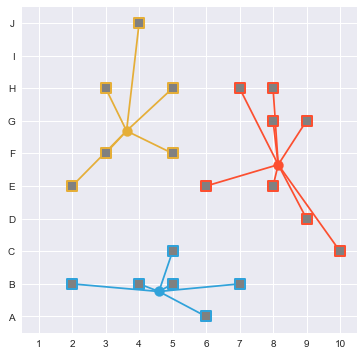

In [16]:
plot_placements(result_anneal, N)


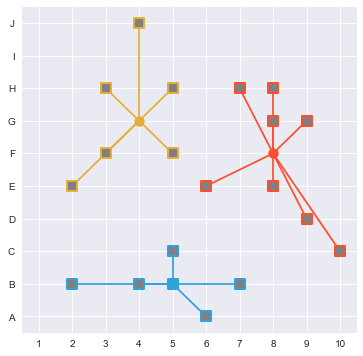

In [17]:
rounded = np.round(result_anneal)
plot_placements(rounded, N)

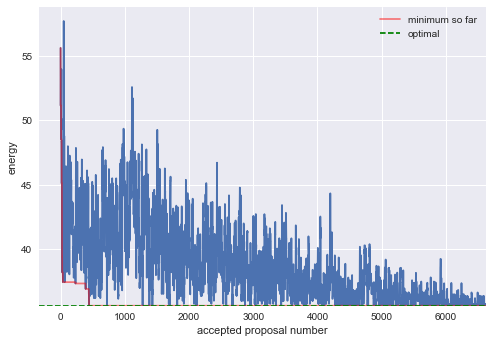

In [18]:
# plot the energies over time
plt.plot(energies_anneal)

# plot the rolling minimum of all proposals so far
plt.plot(np.minimum.accumulate(energies_anneal), 'r', alpha=0.5,
         label='minimum so far')

loss_opt = 35.62746370694812

# plot the optimal value (we know this from brute force, in real world
# stochastic optimization we probably wouldn't)
plt.axhline(y=loss_opt, c='g', ls='--', label='optimal')

plt.ylim(ymin=loss_opt)
plt.xlim(xmax=energies_anneal.size)
plt.xlabel('accepted proposal number')
plt.ylabel('energy')
plt.legend()
plt.show()

In [19]:
rounded = np.round(result_anneal)

In [20]:
rounded

array([[ 8.,  4.],
       [ 4.,  7.],
       [ 3.,  3.]], dtype=float32)